In [1]:
options(warn=-1)
library(tidyverse) # metapackage of all tidyverse packages
#library(plotly) 
library(ggplot2)
library(corrplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

corrplot 0.84 loaded



# Load Data

In [2]:
#load
train <- read.csv("../input/titanic/train.csv")
test <- read.csv("../input/titanic/test.csv")
#see structure
print("Train set")
str(train)
test[duplicated(train),]
sapply(train, function(x) sum(is.na(x)))
print("Test set")
str(test)
train[duplicated(test),]
sapply(test, function(x) sum(is.na(x)))

[1] "Train set"
'data.frame':	891 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 891 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 681 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 148 levels "","A10","A14",..: 1 83 1 57 1 1 131 1 1 1 ...
 $ Embarked   : Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...


PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
<int>,<int>,<fct>,<fct>,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<fct>


PassengerId    Survived      Pclass        Name         Sex         Age 
          0           0           0           0           0         177 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           0           0           0

[1] "Test set"
'data.frame':	418 obs. of  11 variables:
 $ PassengerId: int  892 893 894 895 896 897 898 899 900 901 ...
 $ Pclass     : int  3 3 2 3 3 3 3 2 3 3 ...
 $ Name       : Factor w/ 418 levels "Abbott, Master. Eugene Joseph",..: 210 409 273 414 182 370 85 58 5 104 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 2 2 1 2 1 2 1 2 ...
 $ Age        : num  34.5 47 62 27 22 14 30 26 18 21 ...
 $ SibSp      : int  0 1 0 0 1 0 0 1 0 2 ...
 $ Parch      : int  0 0 0 0 1 0 0 1 0 0 ...
 $ Ticket     : Factor w/ 363 levels "110469","110489",..: 153 222 74 148 139 262 159 85 101 270 ...
 $ Fare       : num  7.83 7 9.69 8.66 12.29 ...
 $ Cabin      : Factor w/ 77 levels "","A11","A18",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 2 3 2 3 3 3 2 3 1 3 ...


PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
<int>,<int>,<int>,<fct>,<fct>,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<fct>


PassengerId      Pclass        Name         Sex         Age       SibSp 
          0           0           0           0          86           0 
      Parch      Ticket        Fare       Cabin    Embarked 
          0           0           1           0           0

In [3]:
#Create set to prepare both train and test simultaneously
train_test <- bind_rows(train,test)
str(train_test)

'data.frame':	1309 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 1307 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 929 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 187 levels "","A10","A14",..: 1 83 1 57 1 1 131 1 1 1 ...
 $ Embarked   : Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...


# Clean and Process Data
There are no duplicated rows, but there are missing values in Age (a lot of them) and in Fare, that need to be treated. <br>
Some variables were considerer as factors in R, and must be transformed to numeric. 

In [4]:
#ASSUMPTIONS - deleted what seems irrelevant
train_test$Name <- NULL # - altough it could be used to aid in missing age assessment
train_test$Ticket <- NULL # - would be awkward if the ticket number was correlated with survival
train_test$Cabin <- NULL # - maybe it could be related, but i'll just assume it's not
train_test$PassengerId <- NULL #they will remain ordered...
print(head(train_test))
str(train_test)

  Survived Pclass    Sex Age SibSp Parch    Fare Embarked
1        0      3   male  22     1     0  7.2500        S
2        1      1 female  38     1     0 71.2833        C
3        1      3 female  26     0     0  7.9250        S
4        1      1 female  35     1     0 53.1000        S
5        0      3   male  35     0     0  8.0500        S
6        0      3   male  NA     0     0  8.4583        Q
'data.frame':	1309 obs. of  8 variables:
 $ Survived: int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass  : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Sex     : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age     : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp   : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch   : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Fare    : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Embarked: Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...


**Gender analysis**

        
           0   1
  female  81 233
  male   468 109

[1] "Gender to numeric"


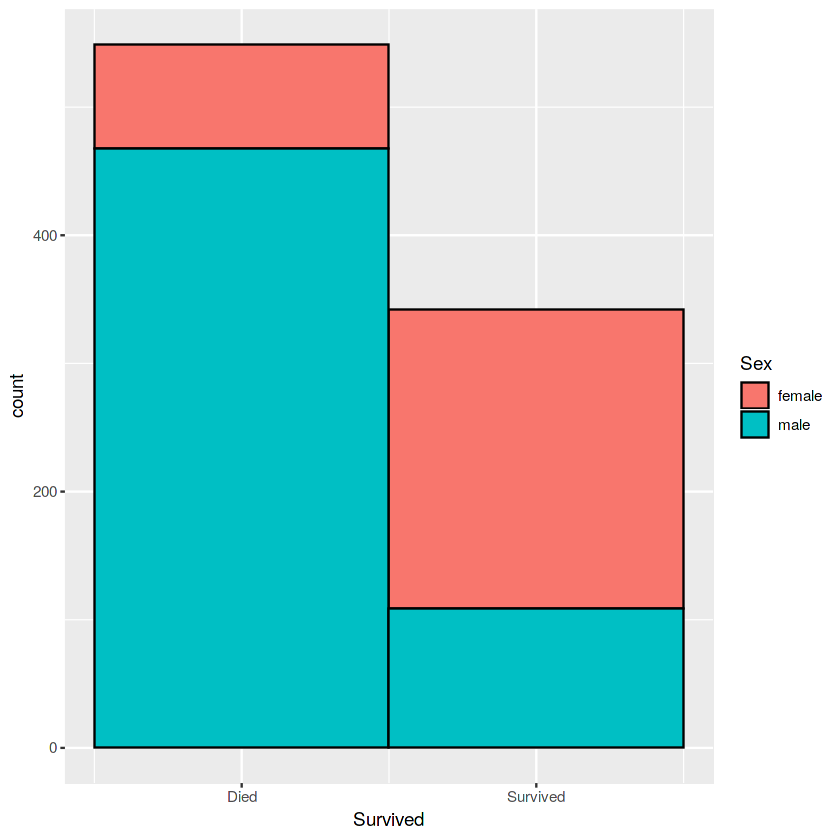

In [5]:
table(train$Sex, train$Survived)

#plot_ly()  %>%
#    add_trace(x= train$Sex, y=train$Survived, name = paste0("Survived"), type = "bar")  %>%
#     add_trace(x= train$Sex, y=+(!train$Survived), name = paste0("Died"), type = "bar")  %>%
#    layout(title = list(text = "Survived by Gender"), yaxis = list(title = 'Survived vs Not'), xaxis = list(type = 'Sex'))  
ggplot(train, aes(x = Survived, fill = Sex)) + geom_histogram(color="black", binwidth = 1) +
  scale_x_continuous(breaks = seq(0,1,1),labels=c("Died","Survived"))


print("Gender to numeric")

train_test$Sex <- as.character(train_test$Sex)             
for (i in 1:length(train_test$Sex)) {
    if (train_test$Sex[i] == "male") {
        train_test$Sex[i] <- 1
    } 
    else if (train_test$Sex[i] == "female") {
        train_test$Sex[i] <- 0
    } 
}
train_test$Sex <- as.numeric(train_test$Sex) 


**Embarkement analysis**

   
      0   1
      0   2
  C  75  93
  Q  47  30
  S 427 217

[1] "Embarked to numeric"
[1] "order embarked as the order they embarked...C = Cherbourg 2, Q = Queenstown 3, S = Southampton 1"
[1] "After NA replacment: "


   
      0   1
  1 427 217
  2  75  95
  3  47  30

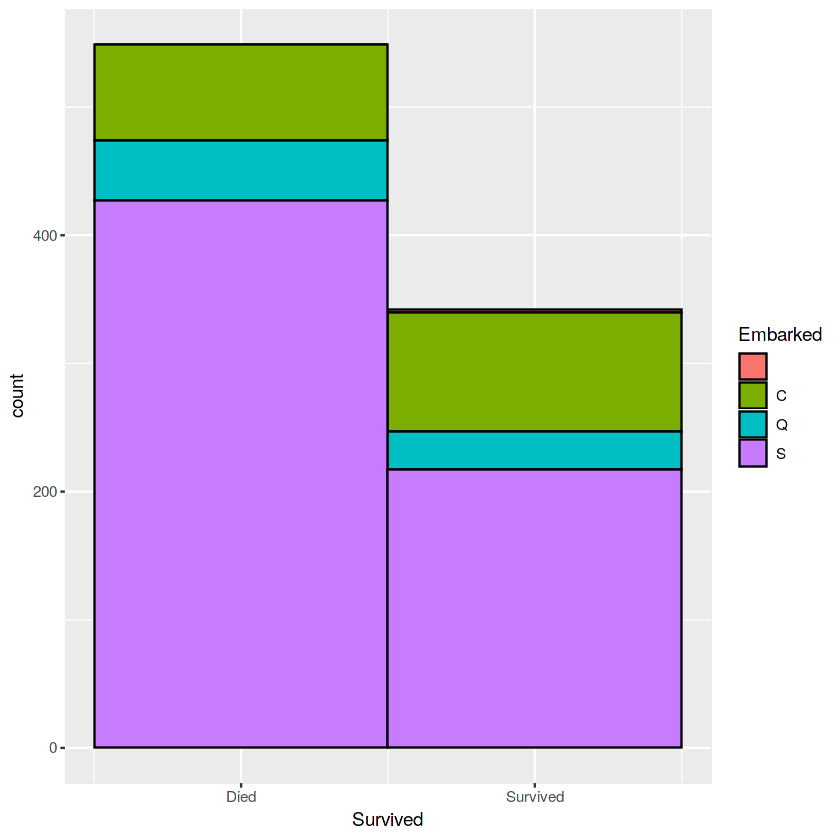

In [6]:
table(train$Embarked, train$Survived)

#plot_ly()  %>%
#    add_trace(x= train$Embarked, y=train$Survived, name = paste0("Survived"), type = "bar")  %>%
#    add_trace(x= train$Embarked, y=+(!train$Survived), name = paste0("Died"), type = "bar")  %>%
#    layout(title = list(text = "Embarked"), yaxis = list(title = 'Survived'), xaxis = list(type = 'Embarked'))  
ggplot(train, aes(x = Survived, fill = Embarked)) + geom_histogram(color="black", binwidth = 1) +
  scale_x_continuous(breaks = seq(0,1,1),labels=c("Died","Survived"))

print("Embarked to numeric")
print("order embarked as the order they embarked...C = Cherbourg 2, Q = Queenstown 3, S = Southampton 1")
#assume NA somewhere around the middle
train_test$Embarked <- as.character(train_test$Embarked)
for (i in 1:length(train_test$Embarked)) {
    if (train_test$Embarked[i] == "C") {
        train_test$Embarked[i] <- 2
    } 
    else if (train_test$Embarked[i] == "Q") {
        train_test$Embarked[i] <- 3
    } 
    else if (train_test$Embarked[i] == "S") {
        train_test$Embarked[i] <- 1
    } 
#Na between 1 and 3 -> 2
    else if (train_test$Embarked[i] == "") {
        train_test$Embarked[i] <- 2 #as.numeric(runif(1, 1, 3))
    } 
}
train_test$Embarked <- as.numeric(train_test$Embarked)
#check how it looks now
print("After NA replacment: ")
table(train_test$Embarked, train_test$Survived) 

**Fare analysis**

[1] "Replace Fare NA with mean value - because of test set"


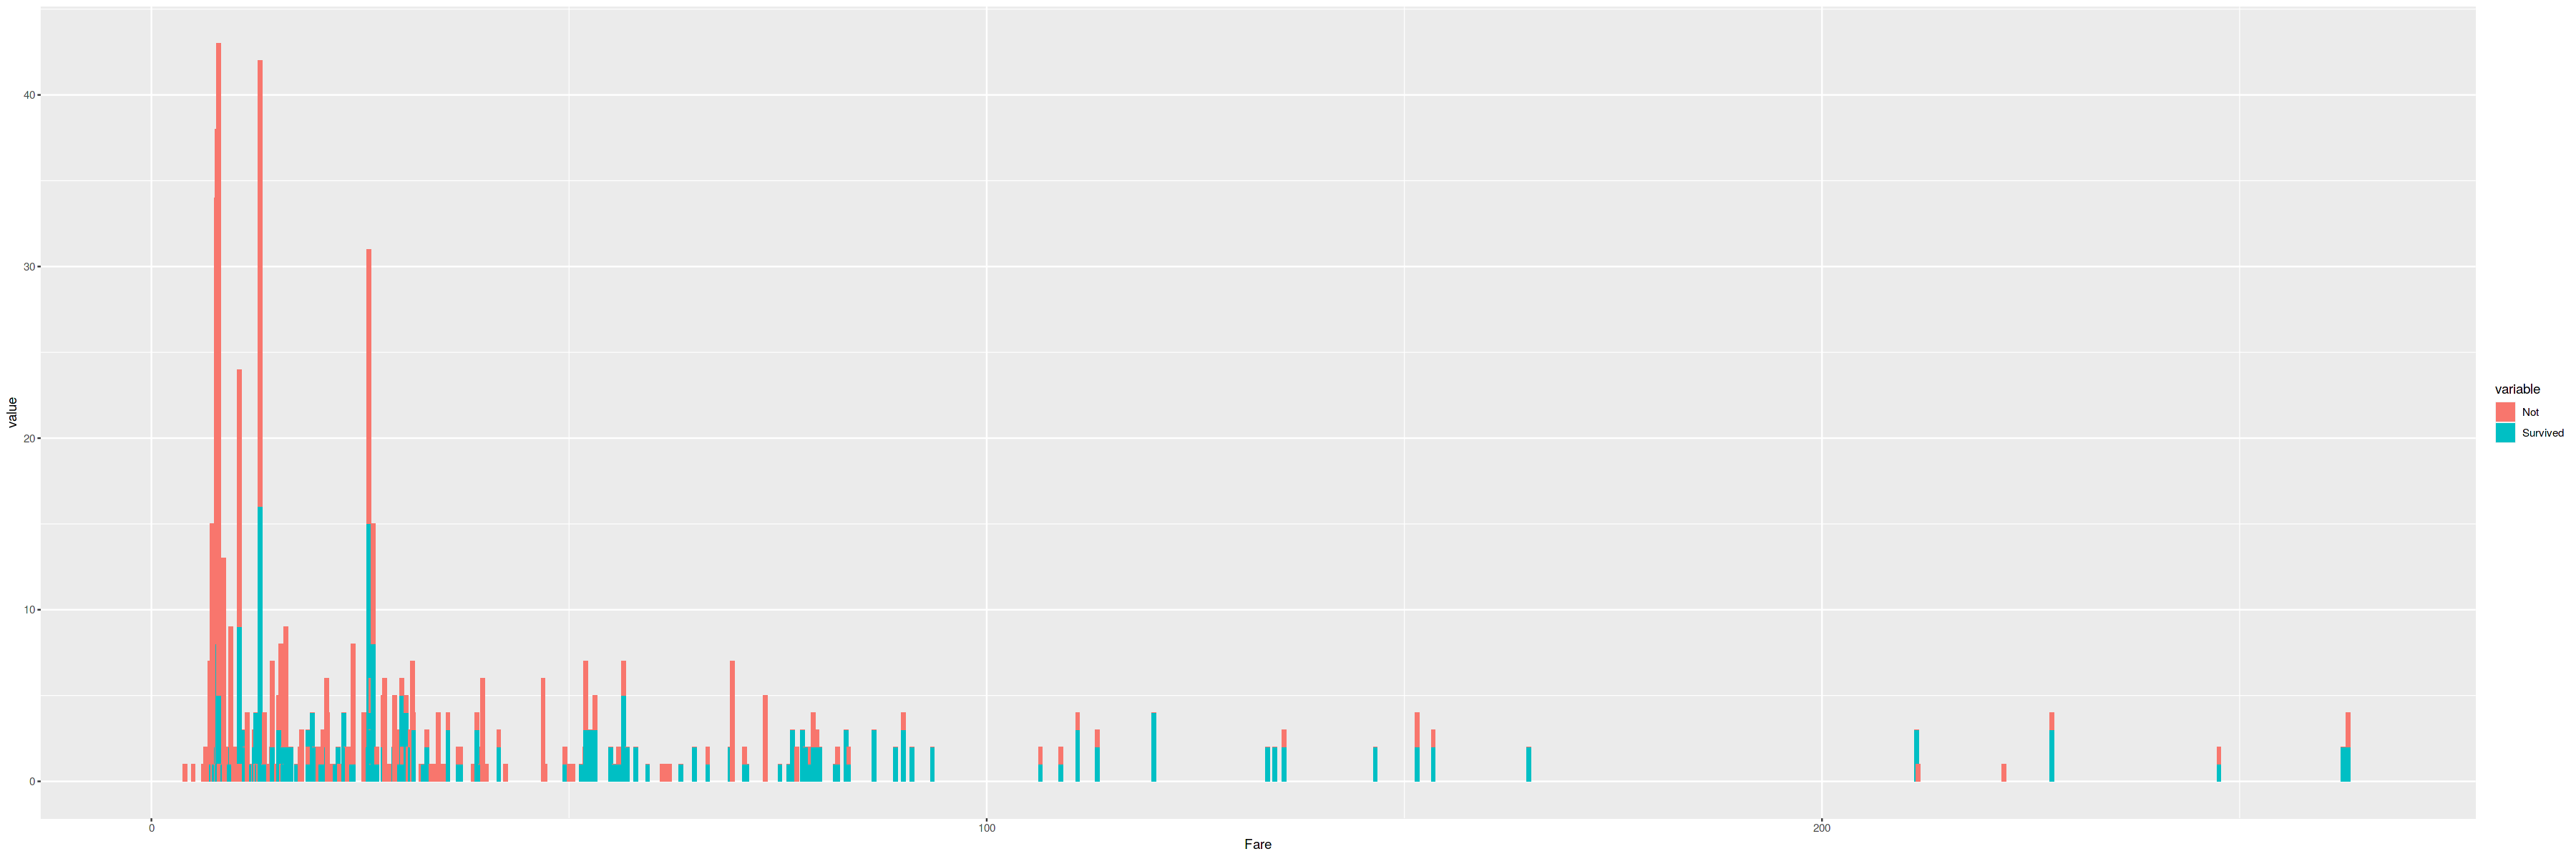

In [7]:
#plot_ly()  %>%
#    add_trace(x= train$Fare, y=train$Survived, name = paste0("Survived"), type = "bar")  %>%
#    add_trace(x= train$Fare, y=+(!train$Survived), name = paste0("Died"), type = "bar")  %>%
#    layout(bargap = 0.05, barmode = 'stack', title = list(text = "Fare"), yaxis = list(title = 'Survived'), xaxis = list(type = 'Age'))
p1<-aggregate(train$Survived=="1"~Fare, sum, data=train)
p2<-aggregate(train$Survived=="0"~Fare, sum, data=train)
p3 <- merge(p1, p2, by.x="Fare") #, by.y="name")
colnames(p3) <- c("Fare", "Survived", "Not")
#head(p3)
p4 <- tidyr::pivot_longer(p3, cols=c('Survived', 'Not'), names_to='variable', values_to="value")
options(repr.plot.width=30, repr.plot.height=10)
ggplot(p4, aes(x=Fare, y=value, fill=variable)) +
    geom_bar(width = 0.5, stat='identity') + xlim(0, 265)

#Replace Fare NA  with mean value - because of test set
print("Replace Fare NA with mean value - because of test set")
train_test$Fare[is.na(train_test$Fare)] <- mean(train_test$Fare, na.rm = TRUE)

**Age analysis**

[1] "Replace Age NA with ... predicted value"


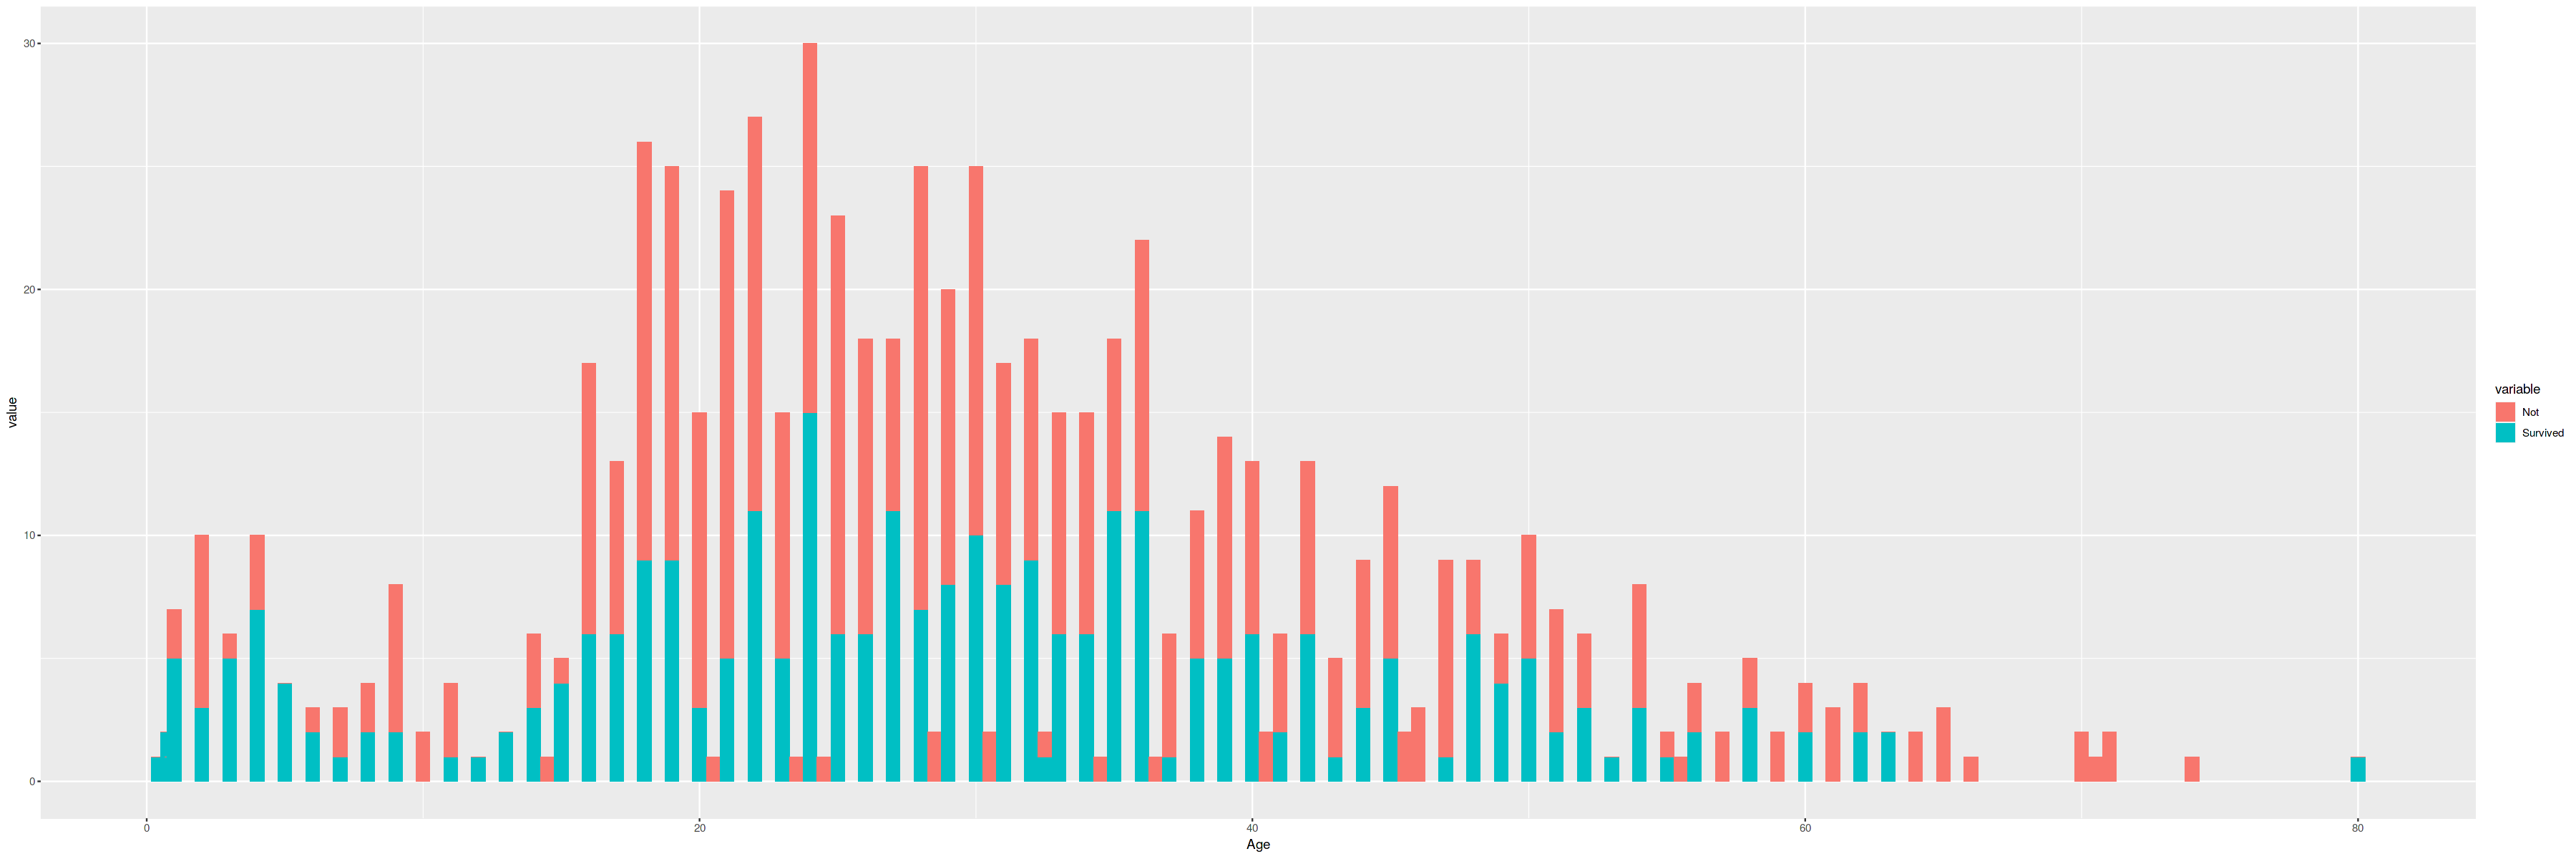


Call:
lm(formula = Age ~ . - 1, data = train0)

Residuals:
    Min      1Q  Median      3Q     Max 
-34.981  -9.734   2.678  19.005  69.005 

Coefficients:
       Estimate Std. Error t value Pr(>|t|)    
Pclass  10.9955     0.3176  34.624   <2e-16 ***
SibSp   -1.2521     0.7583  -1.651    0.099 .  
Parch    1.1623     0.8216   1.415    0.157    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 20.81 on 1043 degrees of freedom
  (263 observations deleted due to missingness)
Multiple R-squared:  0.6076,	Adjusted R-squared:  0.6064 
F-statistic: 538.3 on 3 and 1043 DF,  p-value: < 2.2e-16


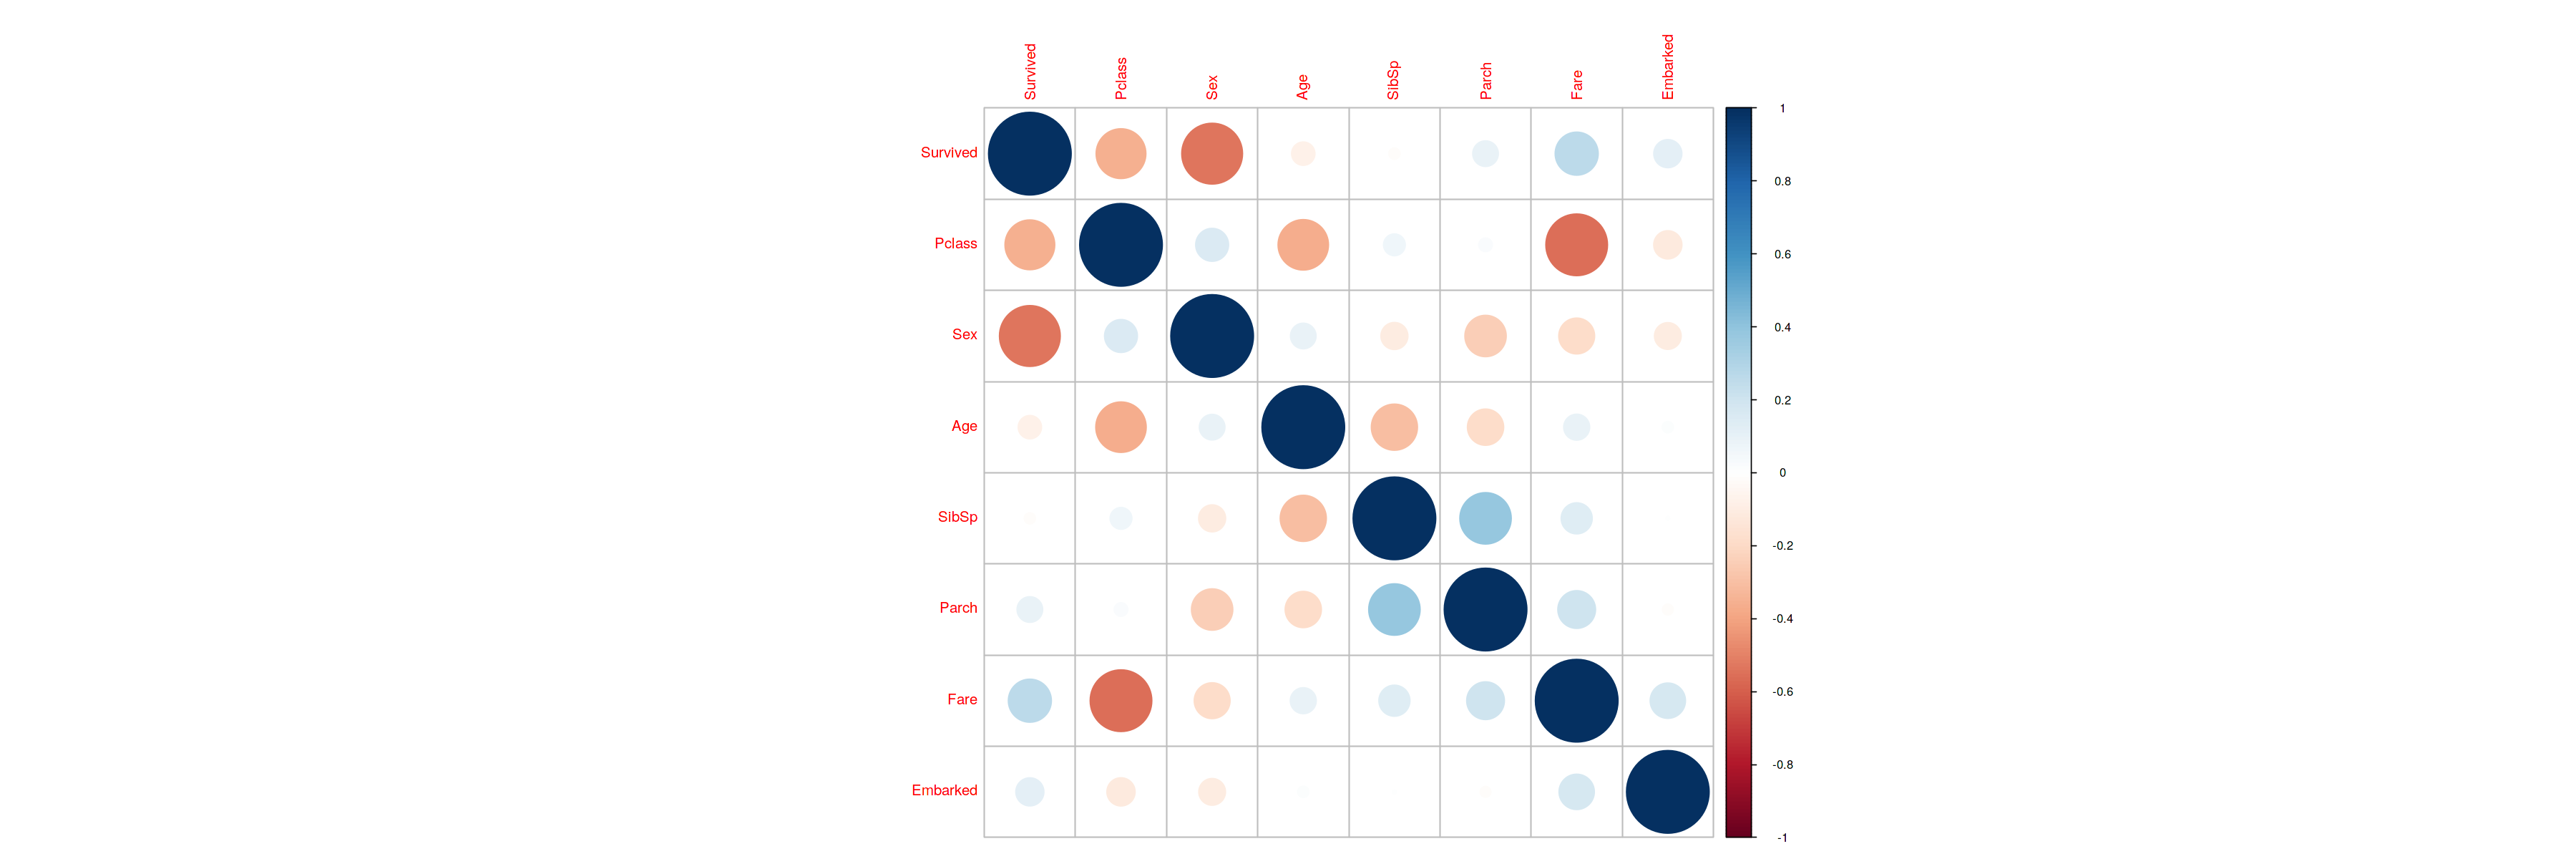

In [8]:
#plot_ly()  %>%
#    add_trace(x= train$Age, y=train$Survived, name = paste0("Survived"), type = "bar")  %>%
#    add_trace(x= train$Age, y=+(!train$Survived), name = paste0("Died"), type = "bar")  %>%
#    layout(bargap = 0.05, barmode = 'stack', title = list(text = "Age"), yaxis = list(title = 'Survived'), xaxis = list(type = 'Age'))
p11<-aggregate(train$Survived=="1"~Age, sum, data=train)
p12<-aggregate(train$Survived=="0"~Age, sum, data=train)
p13 <- merge(p11, p12, by.x="Age") #, by.y="name")
colnames(p13) <- c("Age", "Survived", "Not")
#head(p13)
p14 <- tidyr::pivot_longer(p13, cols=c('Survived', 'Not'), names_to='variable', values_to="value")
options(repr.plot.width=30, repr.plot.height=10)
ggplot(p14, aes(x=Age, y=value, fill=variable)) +
    geom_bar(width = 0.5, stat='identity') 

#Replace Age NA with ... mean value? let's try something better
print("Replace Age NA with ... predicted value")
#check the correlations
correlations <- cor(train_test, method = "pearson", use = "complete.obs")
corrplot(correlations, method="circle")
#Pclass + sibsp + parch are slightly related... 
train0 = train_test[,c("Age","Pclass","SibSp","Parch")]
lm_age = lm(Age ~ . -1, data = train0)
summary(lm_age)
# Use fit to predict the value
train_test <- train_test %>% 
  mutate(pred = predict(lm_age, .)) %>%
  # Replace NA with pred in var1
  mutate(Age = ifelse(is.na(Age), pred, Age))

train_test$pred <- NULL #not needed anymore

**Scale and prepare sets**

In [9]:
#SCALE
train2 <- scale(train_test[,c(-1)])
train2 <- cbind(train2, train_test[,c(1)])
train2 <- as.data.frame(train2)
str(train2)

'data.frame':	1309 obs. of  8 variables:
 $ Pclass  : num  0.842 -1.546 0.842 -1.546 0.842 ...
 $ Sex     : num  0.743 -1.344 -1.344 -1.344 0.743 ...
 $ Age     : num  -0.571 0.624 -0.273 0.4 0.4 ...
 $ SibSp   : num  0.481 0.481 -0.479 0.481 -0.479 ...
 $ Parch   : num  -0.445 -0.445 -0.445 -0.445 -0.445 ...
 $ Fare    : num  -0.503 0.734 -0.49 0.383 -0.488 ...
 $ Embarked: num  -0.605 0.924 -0.605 -0.605 -0.605 ...
 $ V8      : num  0 1 1 1 0 0 0 0 1 1 ...


In [10]:
#Separate again final train and test sets
train_f <- train2[1:891,]
test_f <- train2[892:1309,]
str(train_f)
str(test_f)

'data.frame':	891 obs. of  8 variables:
 $ Pclass  : num  0.842 -1.546 0.842 -1.546 0.842 ...
 $ Sex     : num  0.743 -1.344 -1.344 -1.344 0.743 ...
 $ Age     : num  -0.571 0.624 -0.273 0.4 0.4 ...
 $ SibSp   : num  0.481 0.481 -0.479 0.481 -0.479 ...
 $ Parch   : num  -0.445 -0.445 -0.445 -0.445 -0.445 ...
 $ Fare    : num  -0.503 0.734 -0.49 0.383 -0.488 ...
 $ Embarked: num  -0.605 0.924 -0.605 -0.605 -0.605 ...
 $ V8      : num  0 1 1 1 0 0 0 0 1 1 ...
'data.frame':	418 obs. of  8 variables:
 $ Pclass  : num  0.842 0.842 -0.352 0.842 0.842 ...
 $ Sex     : num  0.743 -1.344 0.743 0.743 -1.344 ...
 $ Age     : num  0.362 1.296 2.416 -0.198 -0.571 ...
 $ SibSp   : num  -0.479 0.481 -0.479 -0.479 0.481 ...
 $ Parch   : num  -0.445 -0.445 -0.445 -0.445 0.71 ...
 $ Fare    : num  -0.492 -0.508 -0.456 -0.476 -0.406 ...
 $ Embarked: num  2.454 -0.605 2.454 -0.605 -0.605 ...
 $ V8      : num  NA NA NA NA NA NA NA NA NA NA ...


# Logistic model - Train set

In [11]:
glm.fit <- glm(V8~., family = binomial,data = train_f)
summary(glm.fit)
glm.probs <- predict(glm.fit,type = "response")


Call:
glm(formula = V8 ~ ., family = binomial, data = train_f)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5326  -0.6052  -0.4236   0.6401   2.3862  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.60971    0.09089  -6.708 1.97e-11 ***
Pclass      -0.83508    0.11268  -7.411 1.26e-13 ***
Sex         -1.29636    0.09476 -13.681  < 2e-16 ***
Age         -0.40092    0.09189  -4.363 1.28e-05 ***
SibSp       -0.31871    0.10976  -2.904  0.00369 ** 
Parch       -0.06705    0.10054  -0.667  0.50485    
Fare         0.13141    0.12273   1.071  0.28432    
Embarked     0.17835    0.09244   1.929  0.05369 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1186.66  on 890  degrees of freedom
Residual deviance:  793.88  on 883  degrees of freedom
AIC: 809.88

Number of Fisher Scoring iterations: 5


**Optimize cuttoff value**

In [12]:
#Optimization - it's a small problem, so all enumeration is enough
max <- 0
for (p in seq(0.05,0.95, by=0.05)) {
    pred0 <- ifelse(glm.probs > p, 1, 0)
    a <- table(Predictions = pred0, TrueLabels = train_f$V8)
    acc0 <- ( a[2,2] + a[1,1] ) / (length(train_f$V8))
    if (acc0 >=max) {
        max <- acc0
        acc_opt <- p
    }
}
print(acc_opt)

#Finally
pred <- ifelse(glm.probs > acc_opt, 1, 0)
paste0(sum(pred) , " vs " , sum(train$Survived))
#how they look
head(pred,50)

[1] 0.6


[1] "268 vs 342"

1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
 0  1  1  1  0  0  0  0  0  1  1  1  0  0  1  1  0  0  0  1  0  0  1  0  0  0 
27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
 0  0  1  0  0  1  1  0  0  0  0  0  0  1  0  1  0  1  1  0  0  1  0  1

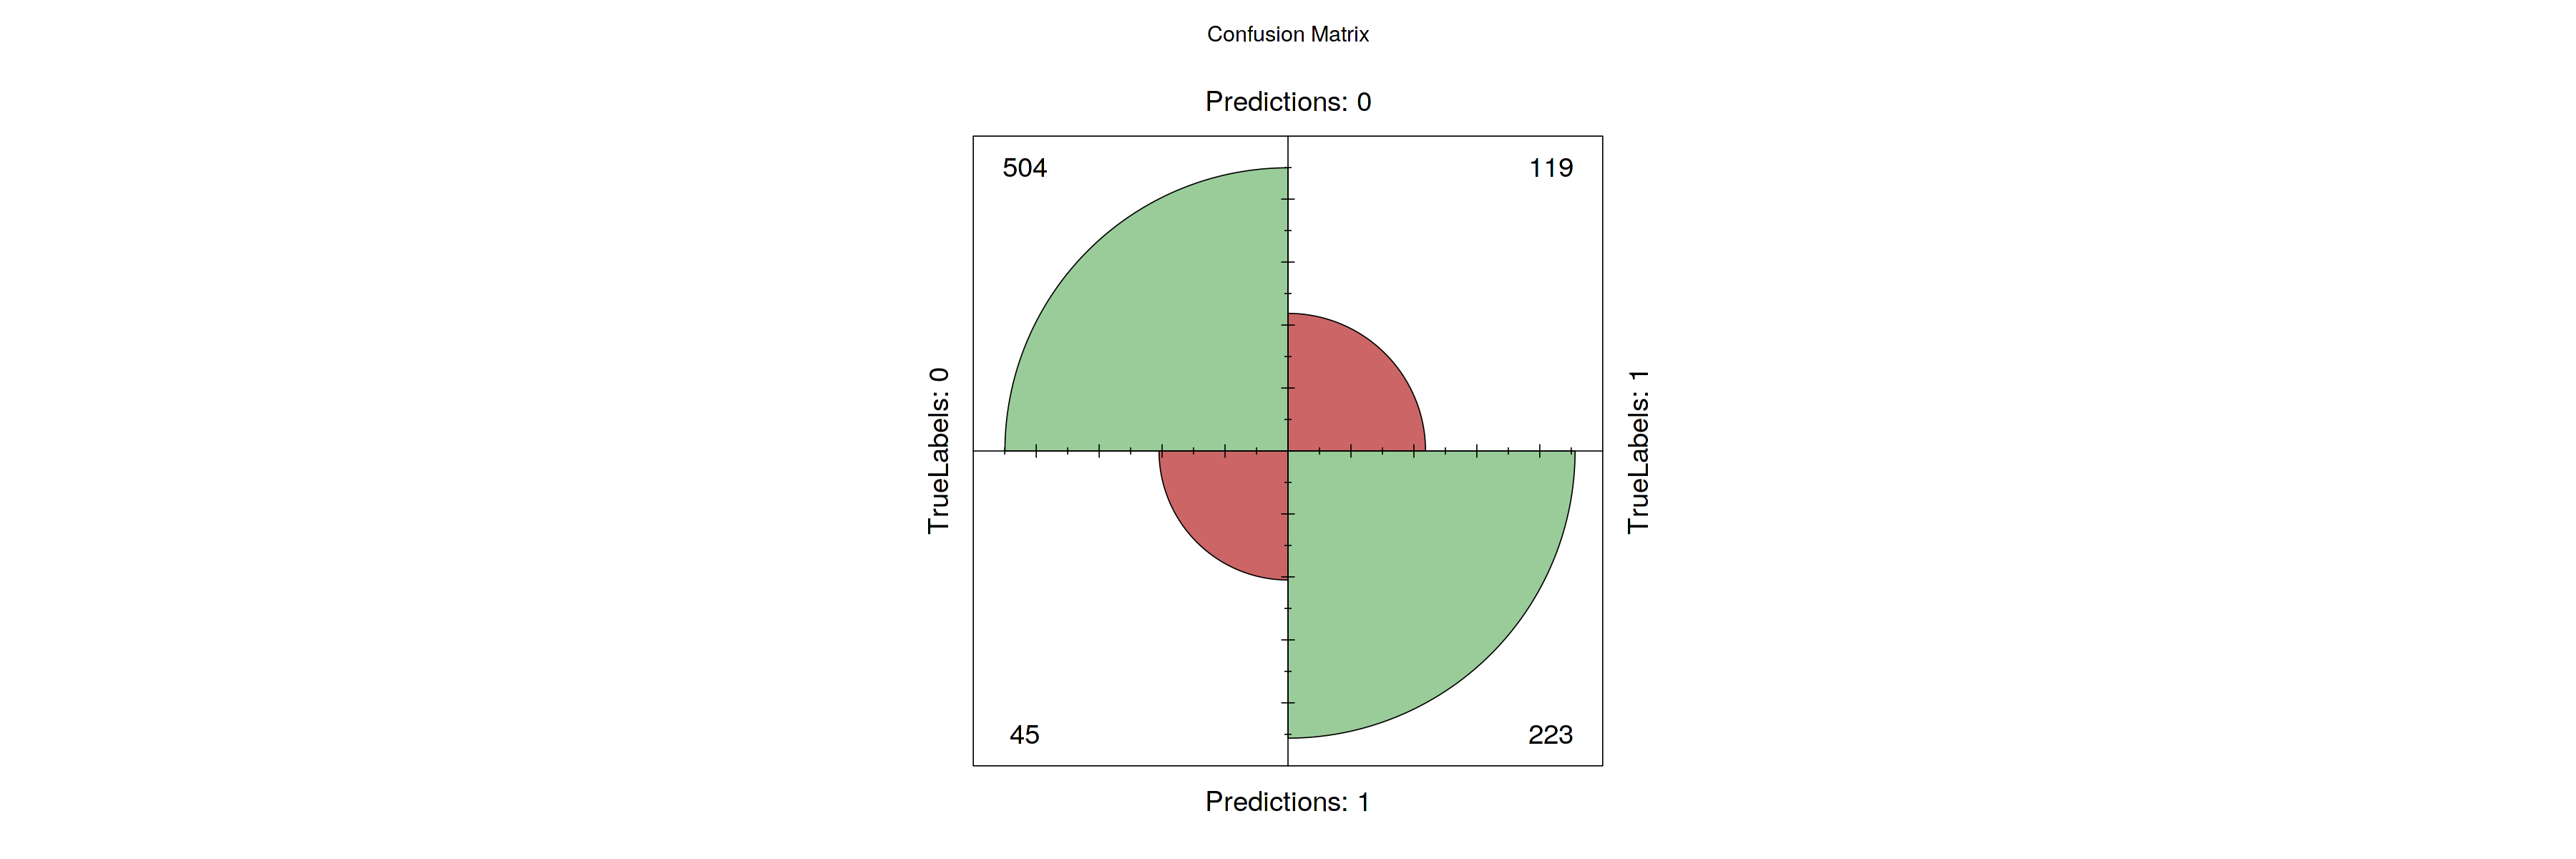

In [13]:
#Confusion Matrix
a <- table(Predictions = pred, TrueLabels = train_f$V8)
fourfoldplot(a, color = c("#CC6666", "#99CC99"),
             conf.level = 0, margin = 1, main = "Confusion Matrix")

In [14]:
#Accuracy
acc <- ( a[2,2] + a[1,1] ) / (length(train_f$V8))
print(paste0("Accuracy = ",acc))
#Error Rate
err <- ( a[2,1] + a[1,2] ) / (length(train_f$V8))
print(paste0("Error Rate = ",err))

[1] "Accuracy = 0.815937149270483"
[1] "Error Rate = 0.184062850729517"


# Logistic model - Test set and submission

In [15]:
glm.probs2 <- predict(glm.fit, newdata = test_f, type = "response")
pred2 <- ifelse(glm.probs2 > acc_opt, 1, 0)
#how it looks
head(pred2,50)

892 893 894 895 896 897 898 899 900 901 902 903 904 905 906 907 908 909 910 911 
  0   0   0   0   0   0   1   0   1   0   0   0   1   0   1   1   0   0   0   0 
912 913 914 915 916 917 918 919 920 921 922 923 924 925 926 927 928 929 930 931 
  0   0   1   0   1   0   1   0   0   0   0   0   0   0   0   0   0   1   0   0 
932 933 934 935 936 937 938 939 940 941 
  0   0   0   1   1   0   0   0   1   0

In [16]:
submit = data.frame(PassengerId = c(892:1309), Survived = pred2)
head(submit)

,PassengerId,Survived
,<int>,<dbl>
892,892,0
893,893,0
894,894,0
895,895,0
896,896,0
897,897,0


    Survived Pclass Sex  Age SibSp Parch    Fare Embarked pred2
892       NA      3   1 34.5     0     0  7.8292        3     0
893       NA      3   0 47.0     1     0  7.0000        1     0
894       NA      2   1 62.0     0     0  9.6875        3     0
895       NA      3   1 27.0     0     0  8.6625        1     0
896       NA      3   0 22.0     1     1 12.2875        1     0
897       NA      3   1 14.0     0     0  9.2250        1     0


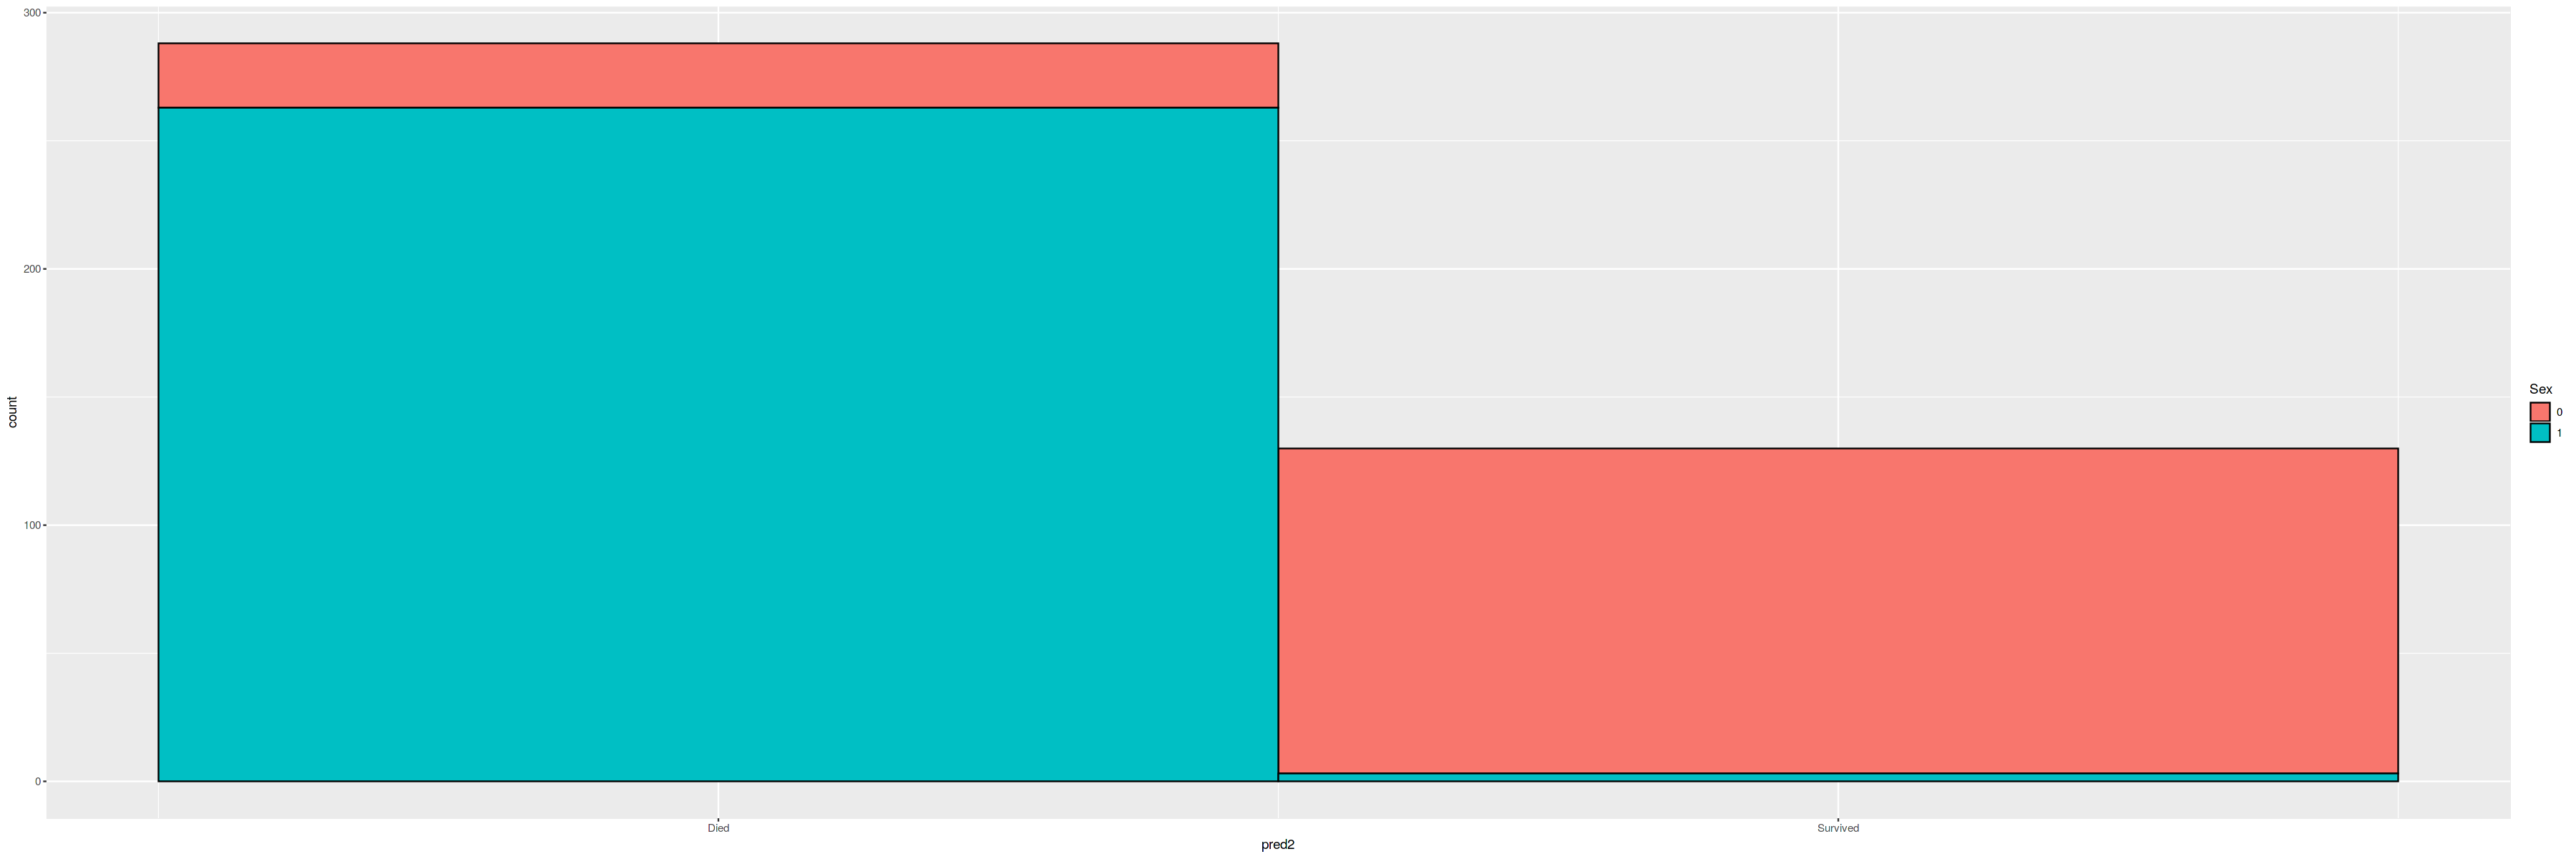

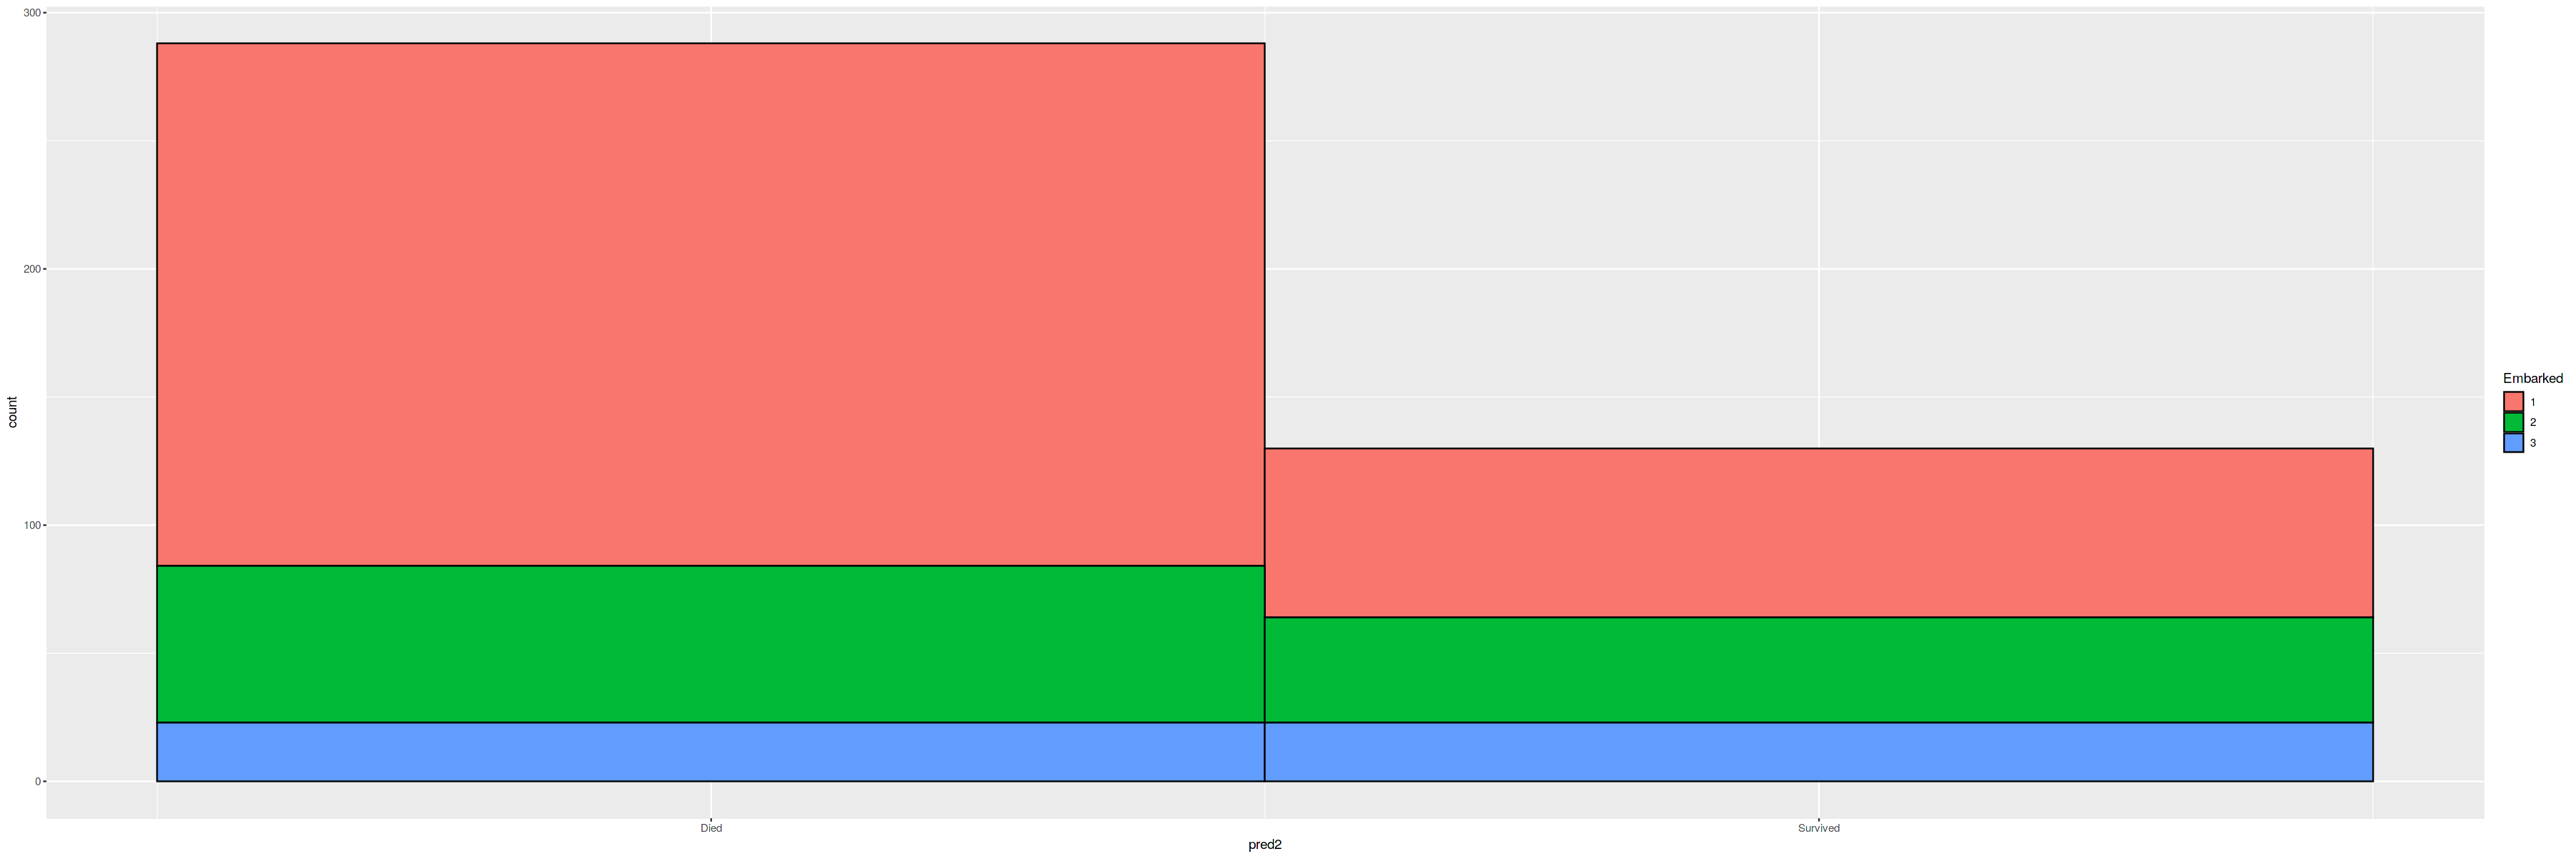

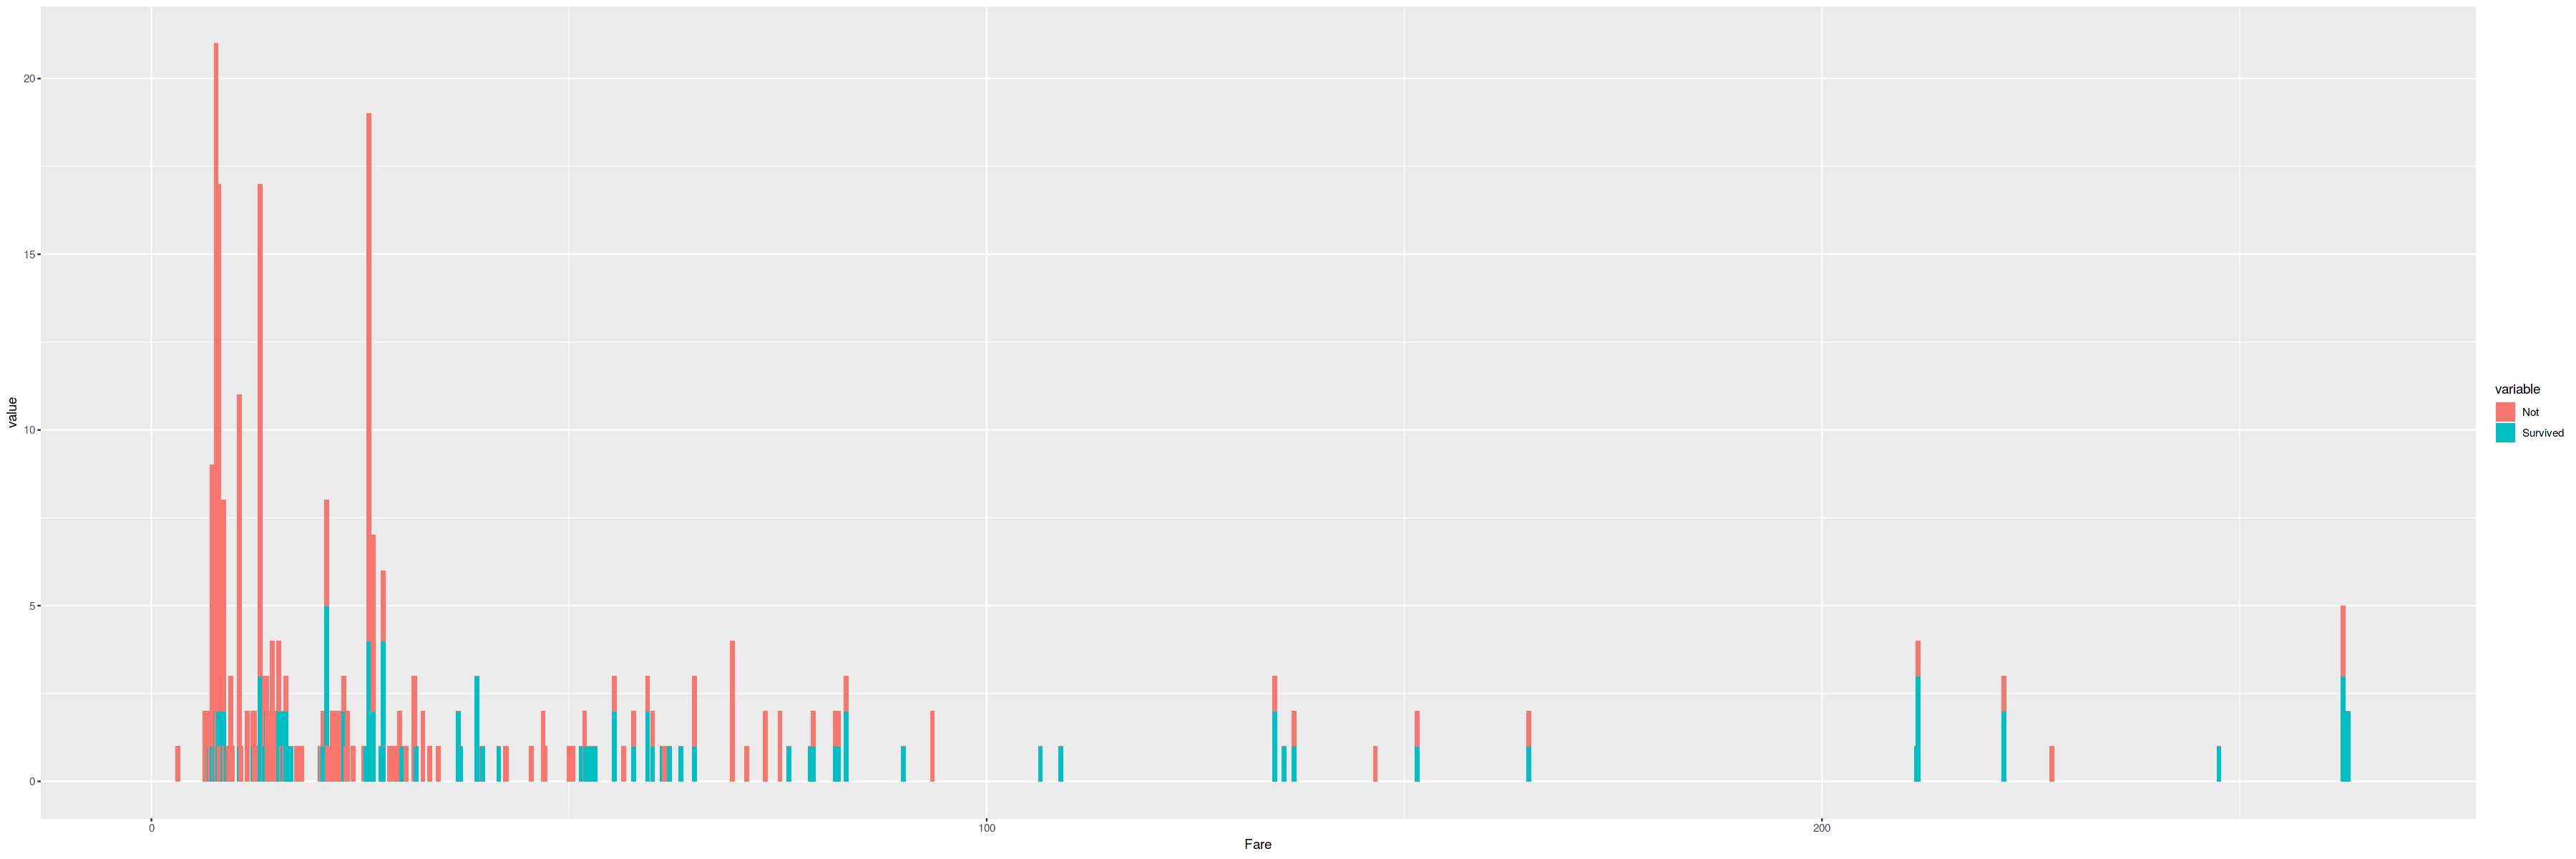

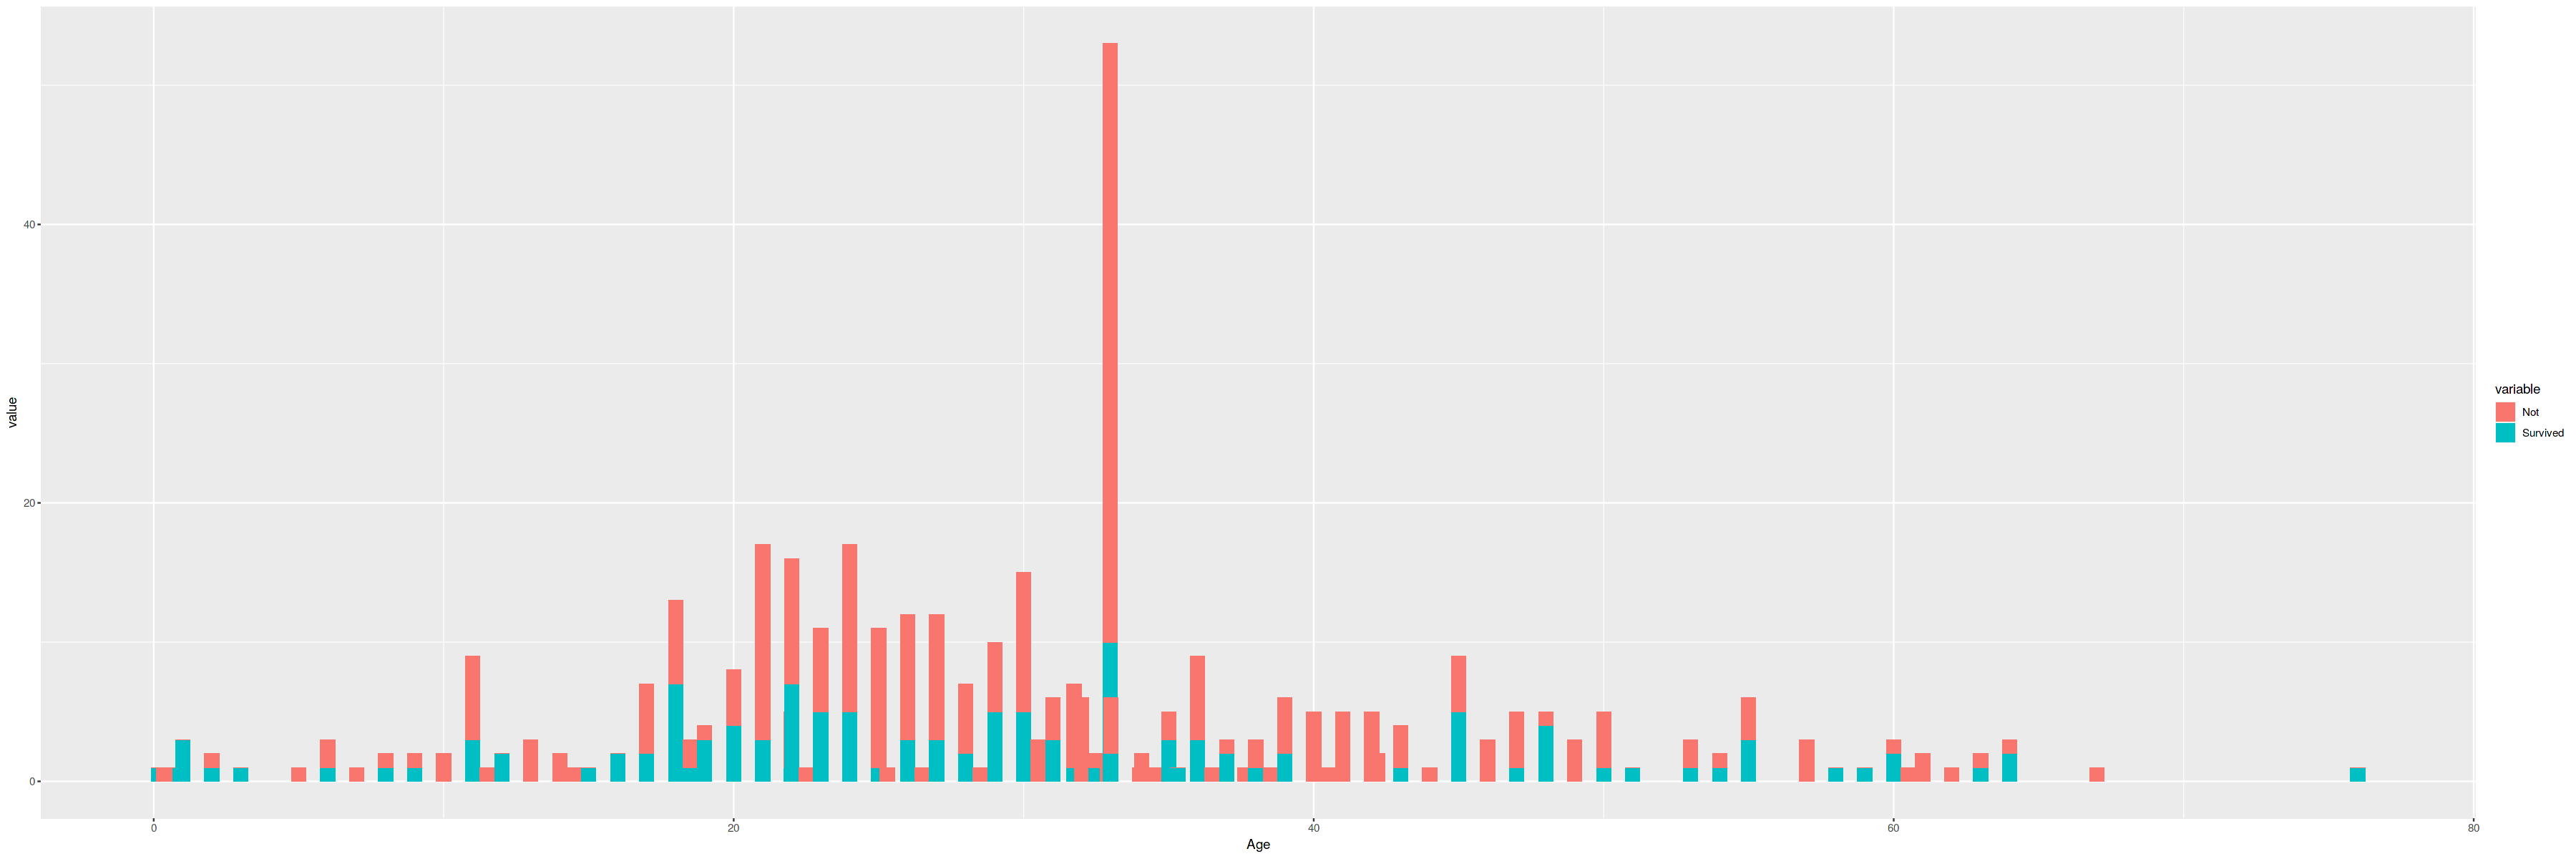

In [17]:
#Check if it makes sense... go back to unscaled test set and add new prediction
test_f_check <- cbind(train_test[892:1309,],pred2)
print(head(test_f_check))

#Gender
#plot_ly()  %>%
#    add_trace(x= test_f_check$Sex, y=test_f_check$pred2, name = paste0("Survived"), type = "bar")  %>%
#     add_trace(x= test_f_check$Sex, y=+(!test_f_check$pred2), name = paste0("Died"), type = "bar")  %>%
#    layout(title = list(text = "Survived by Gender"), yaxis = list(title = 'Survived vs Not'), xaxis = list(type = 'Sex'))
test_f_check$Sex <- as.factor(test_f_check$Sex) 
ggplot(test_f_check, aes(x = pred2, fill = Sex)) + geom_histogram(color="black", binwidth = 1) +
  scale_x_continuous(breaks = seq(0,1,1),labels=c("Died","Survived"))
#Embarked
#plot_ly()  %>%
#    add_trace(x= test_f_check$Embarked, y=test_f_check$pred2, name = paste0("Survived"), type = "bar")  %>%
#    add_trace(x= test_f_check$Embarked, y=+(!test_f_check$pred2), name = paste0("Died"), type = "bar")  %>%
#    layout(title = list(text = "Embarked"), yaxis = list(title = 'Survived'), xaxis = list(type = 'Embarked')) 
test_f_check$Embarked <- as.factor(test_f_check$Embarked) 
ggplot(test_f_check, aes(x = pred2, fill = Embarked)) + geom_histogram(color="black", binwidth = 1) +
  scale_x_continuous(breaks = seq(0,1,1),labels=c("Died","Survived"))
#Fare
#plot_ly()  %>%
#    add_trace(x= test_f_check$Fare, y=test_f_check$pred2, name = paste0("Survived"), type = "bar")  %>%
#    add_trace(x= test_f_check$Fare, y=+(!test_f_check$pred2), name = paste0("Died"), type = "bar")  %>%
#    layout(bargap = 0.05, barmode = 'stack', title = list(text = "Fare"), yaxis = list(title = 'Survived'), xaxis = list(type = 'Age'))
p1<-aggregate(test_f_check$pred2=="1"~Fare, sum, data=test_f_check)
p2<-aggregate(test_f_check$pred2=="0"~Fare, sum, data=test_f_check)
p3 <- merge(p1, p2, by.x="Fare") #, by.y="name")
colnames(p3) <- c("Fare", "Survived", "Not")
p4 <- tidyr::pivot_longer(p3, cols=c('Survived', 'Not'), names_to='variable', values_to="value")
ggplot(p4, aes(x=Fare, y=value, fill=variable)) +
    geom_bar(width = 0.5, stat='identity') + xlim(0, 265)
#Age
#plot_ly()  %>%
#    add_trace(x= test_f_check$Age, y=test_f_check$pred2, name = paste0("Survived"), type = "bar")  %>%
#    add_trace(x= test_f_check$Age, y=+(!test_f_check$pred2), name = paste0("Died"), type = "bar")  %>%
#    layout(bargap = 0.05, barmode = 'stack', title = list(text = "Age"), yaxis = list(title = 'Survived'), xaxis = list(type = 'Age'))
p11<-aggregate(test_f_check$pred2=="1"~Age, sum, data=test_f_check)
p12<-aggregate(test_f_check$pred2=="0"~Age, sum, data=test_f_check)
p13 <- merge(p11, p12, by.x="Age") #, by.y="name")
colnames(p13) <- c("Age", "Survived", "Not")
p14 <- tidyr::pivot_longer(p13, cols=c('Survived', 'Not'), names_to='variable', values_to="value")
ggplot(p14, aes(x=Age, y=value, fill=variable)) +
    geom_bar(width = 0.5, stat='identity') 

It seems reasonable... except for men, which are being 'murdered' by this model! :) <br>
Let's just submit it!

In [18]:
#SUBMIT!!!!
write.csv(submit, "submission.csv", row.names = FALSE)
print("Submission successfully saved!")

[1] "Submission successfully saved!"
